# MLP Comparison Doc
------------------------------------------------------


Goal: setup a test bench to train and test MLP with different data and params

### Imports:

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Datasets:

In [824]:
from torchvision import datasets, transforms

img_res = (18, 24)  # SET RESOLUTION


resize_transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                transforms.Resize(img_res)
                              ])
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=resize_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=resize_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


0
tensor([[[-1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
          -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
          -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
          -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
          -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00],
         [-1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
          -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
          -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
          -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
          -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00],
         [-1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
          -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
          -9.3516e-01, -5.1736e-01, -2.5911e-01, -2.8659e-01, -7.4207e-01,
          -1.0000e+00, -1.0000e+00, -1.0000e+00

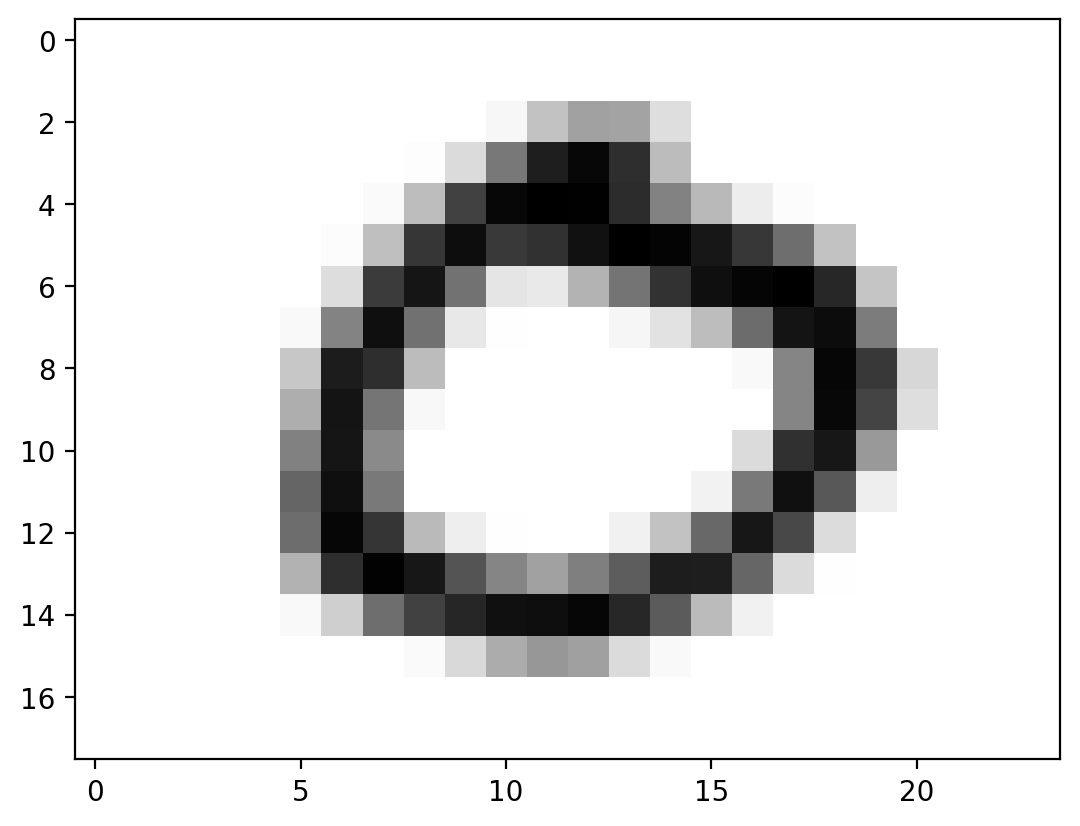

In [825]:
### Check images

dataiter = iter(trainloader)   # To iterate through the dataset
images, labels = next(dataiter)
plt.imshow(images[0].numpy().reshape(img_res), cmap='binary')
print(labels[0].item())
print(images[0])


### MLP:

In [609]:
class MLP(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,nlabels,epochs=100,lr=0.001,dropout=0.1): # nlabels = 10 for digit classification
        super().__init__()

        # MODEL ARCHITECTURE:
        self.output1 = nn.Linear(dimx,hidden1)
        self.output2 = nn.Linear(hidden1,hidden2)
        self.output3 = nn.Linear(hidden2,nlabels)
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(p=dropout)

        # Other params
        self.lr = lr #Learning Rate
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.NLLLoss()

        # A list to store the loss evolution along training
        self.loss_during_training = []
        self.test_loss_during_training = []

    ### INFERENCE ###
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)
        x = self.output2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.output3(x)
        x = self.dropout(x)
        x = self.logsoftmax(x) # logsoftmax: probabilities for each of the ten outputs
        return x

    def forward_preActivation(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)
        x = self.output2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.output3(x)
        x = self.dropout(x) # DON'T APPLY SOFTMAX
        return x


    ### TRAINING ###
    def train(self,trainloader,testloader,epochs=self.epochs):
    
            # Optimization Loop
            for e in range(int(self.epochs)):
    
                # Random data permutation at each epoch
                running_loss = 0.
                testing_loss = 0.

                # TRAINING LOSS
                for images, labels in trainloader:             
    
                    self.optim.zero_grad()  #TO RESET GRADIENTS!
    
                    out = self.forward(images.view(images.shape[0], -1))
    
                    # Compute loss
                    loss = self.criterion(out,labels)
    
                    running_loss += loss.item()
    
                    # Compute gradients (back propagation)
                    loss.backward()
    
                    # Update weights
                    self.optim.step()

                # TESTING LOSS
                with torch.no_grad():
                    for images, labels in testloader:             
        
                        out = self.forward(images.view(images.shape[0], -1))
        
                        # Compute loss
                        loss = self.criterion(out,labels)
        
                        testing_loss += loss.item()

                self.loss_during_training.append(running_loss/len(trainloader))
                self.test_loss_during_training.append(testing_loss/len(testloader))
    
                if(e % 1 == 0): # Every 10 epochs
    
                    print("Training loss after %d epochs: %f"
                          %(e,self.loss_during_training[-1]))

    ### COMPUTE ACCURACY ###
    def eval_performance(self,dataloader):

        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in dataloader:

                logprobs = self.forward(images.view(images.shape[0], -1))

                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))

            return accuracy/len(dataloader)

### Training:

Train Accuracy 0.385478
Test Accuracy 0.384554


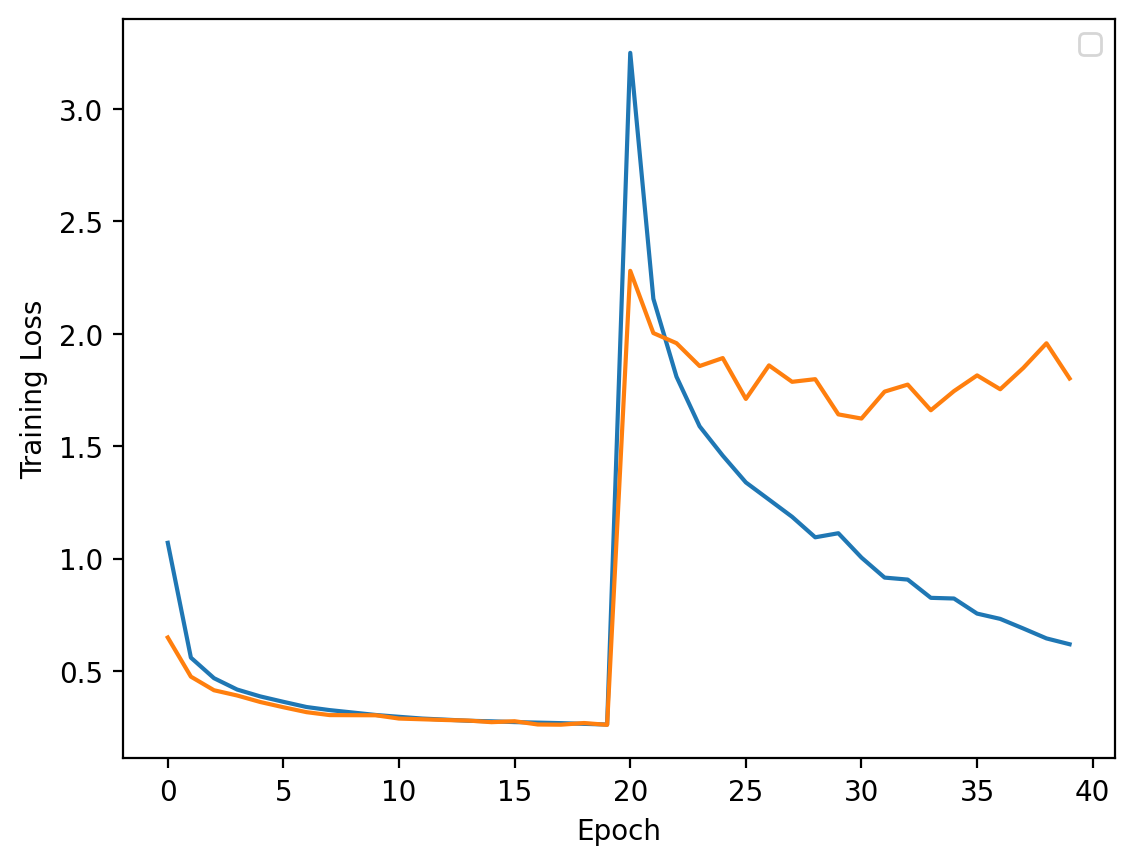

In [908]:
#my_MLP = MLP(dimx=img_res[0]*img_res[1],hidden1=16,hidden2=8,nlabels=10,epochs=20,lr=1e-3,dropout=0)

#my_MLP.train(trainloader, testloader)

train_performance = my_MLP.eval_performance(trainloader)

test_performance = my_MLP.eval_performance(testloader)

print("Train Accuracy %f" %(train_performance))

print("Test Accuracy %f" %(test_performance))

plt.ylabel("Training Loss")
plt.xlabel("Epoch")
plt.legend(["Training Loss", "Testing Loss"])
plt.plot(my_MLP.loss_during_training)
fig = plt.plot(my_MLP.test_loss_during_training)

Training loss after 0 epochs: 3.250301
Training loss after 1 epochs: 2.156202
Training loss after 2 epochs: 1.809271
Training loss after 3 epochs: 1.588575
Training loss after 4 epochs: 1.458147
Training loss after 5 epochs: 1.338918
Training loss after 6 epochs: 1.262494
Training loss after 7 epochs: 1.185876
Training loss after 8 epochs: 1.094692
Training loss after 9 epochs: 1.112806
Training loss after 10 epochs: 1.004430
Training loss after 11 epochs: 0.915382
Training loss after 12 epochs: 0.906579
Training loss after 13 epochs: 0.825344
Training loss after 14 epochs: 0.822369
Training loss after 15 epochs: 0.755233
Training loss after 16 epochs: 0.731674
Training loss after 17 epochs: 0.688880
Training loss after 18 epochs: 0.644845
Training loss after 19 epochs: 0.618844
Train Accuracy 0.847222
Test Accuracy 0.648148


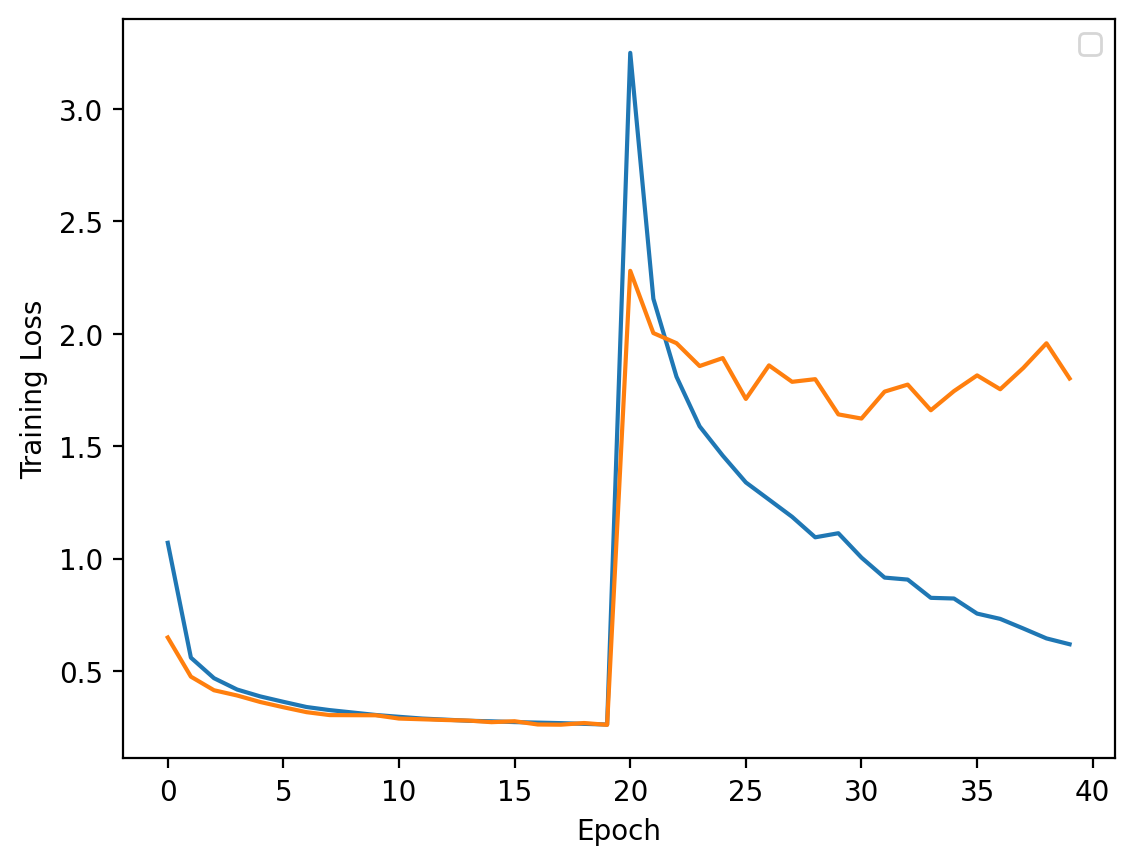

In [879]:
# tuning?
my_MLP.train(camera_trainloader, camera_testloader)

train_performance = my_MLP.eval_performance(camera_trainloader)

test_performance = my_MLP.eval_performance(camera_testloader)

print("Train Accuracy %f" %(train_performance))

print("Test Accuracy %f" %(test_performance))

plt.ylabel("Training Loss")
plt.xlabel("Epoch")
plt.legend(["Training Loss", "Testing Loss"])
plt.plot(my_MLP.loss_during_training)
fig = plt.plot(my_MLP.test_loss_during_training)

In [907]:
train_performance = my_MLP.eval_performance(camera_trainloader)

test_performance = my_MLP.eval_performance(camera_testloader)

print("Train Accuracy %f" %(train_performance))

print("Test Accuracy %f" %(test_performance))

Train Accuracy 0.843537
Test Accuracy 0.864865


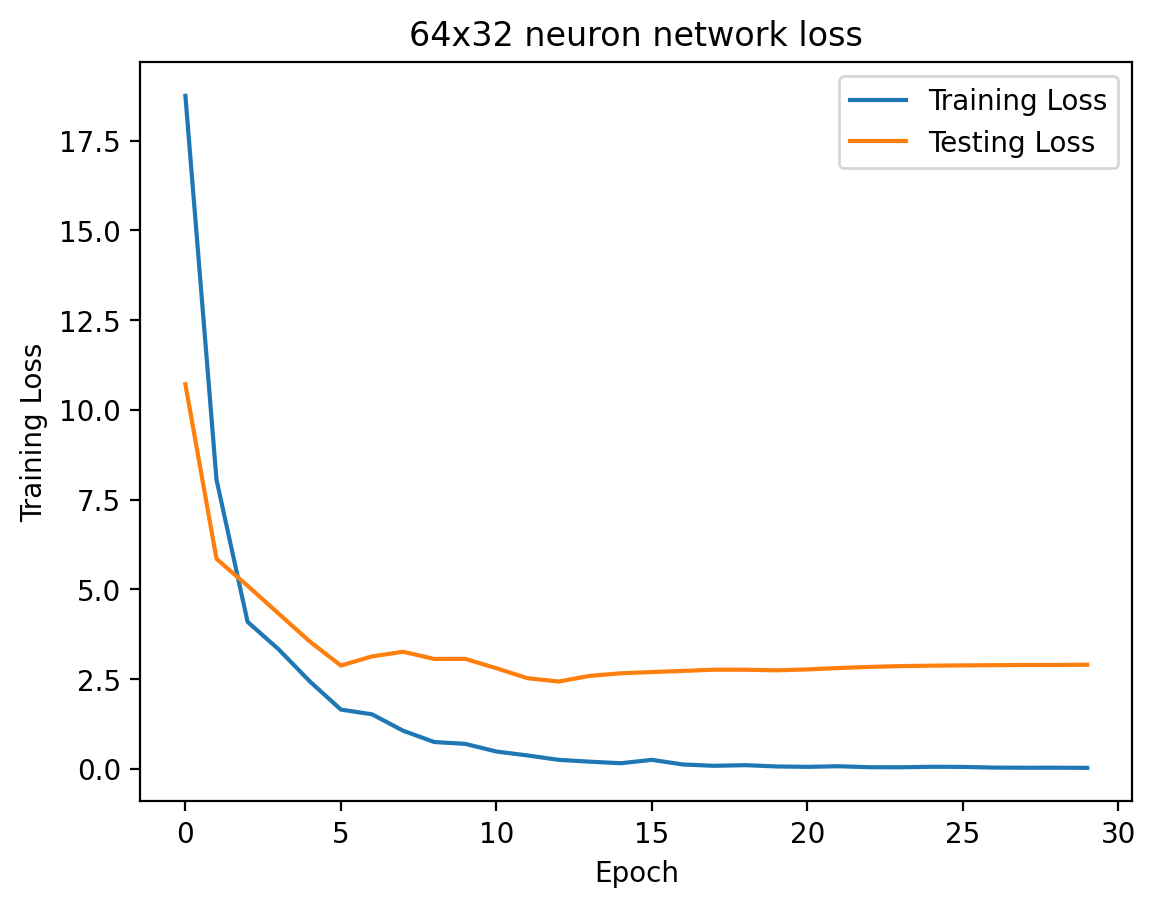

In [611]:
plt.ylabel("Training Loss")
plt.xlabel("Epoch")
plt.plot(my_MLP.loss_during_training)
plt.plot(my_MLP.test_loss_during_training)
plt.title("64x32 neuron network loss")
fig = plt.legend(["Training Loss", "Testing Loss"])

### CAMERA IMAGE EXPLORATION:

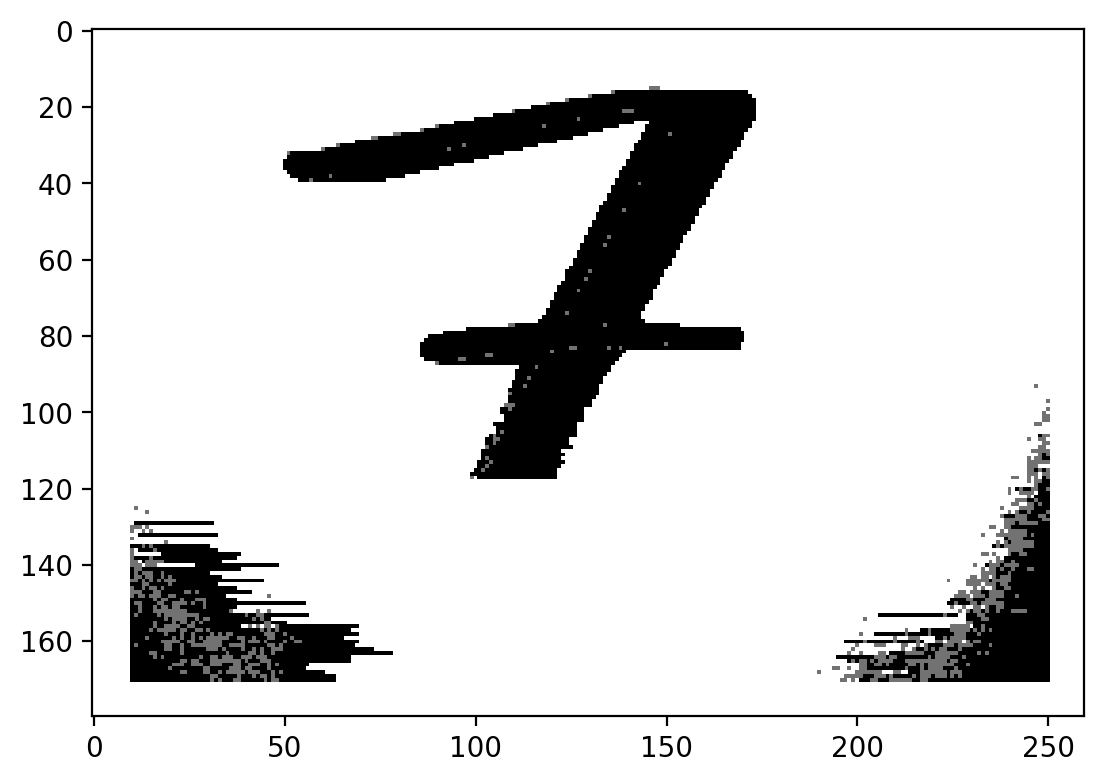

In [584]:
input_dir = "../../TRAINING_SET"
file_name = os.listdir(input_dir)[54]
input_path = os.path.join(input_dir, file_name)

img = Image.open(input_path).convert('L')
img_array = np.array(img) / 260
smudging = [0, 0]
cropping = 30
for row in range(img_array.shape[0]):
    for col in range(img_array.shape[1]):
        if(row < 40 or row > 200 or col < 40 or col > 280):
            img_array[row][col] = 0
        elif img_array[row][col] < 0.55:
            img_array[row][col] = 1
            smudging = [row, col]
        elif img_array[row][col] > 0.55:
            if((row >= smudging[0] and row <= smudging[0] + 10) and (col >= smudging[1] and col <= smudging[1] + 20)):
                img_array[row][col] = 1
            else:
                img_array[row][col] = 0
            
img_array = img_array[cropping:240-cropping, cropping:320-cropping] * 255
fig = plt.imshow(img_array, cmap='binary')

In [861]:
### CREATE THE PREPROCESSED DATASET FOLDER
from PIL import Image
import os
output_dir = "../../preprocessed_set"
input_dir = "../../TRAINING_SET"

for file_name in os.listdir(input_dir):
    if file_name.endswith(".bmp"):
        input_path = os.path.join(input_dir, file_name)
        output_path = os.path.join(output_dir, file_name)

        # Open and preprocess
        img = Image.open(input_path).convert('L')
        img_array = np.array(img) / 260
        smudging = [0, 0]
        cropping = 30
        for row in range(img_array.shape[0]):
            for col in range(img_array.shape[1]):
                if(row < 30 or row > 210 or col < 30 or col > 290):
                    img_array[row][col] = 0
                elif img_array[row][col] < 0.6:
                    img_array[row][col] = 1
                    smudging = [row, col]
                elif img_array[row][col] > 0.6:
                    if((row >= smudging[0] and row <= smudging[0] + 10) and (col >= smudging[1] and col <= smudging[1] + 20)):
                        img_array[row][col] = 1
                    else:
                        img_array[row][col] = 0

        
        img_array = img_array[cropping:240-cropping, cropping:320-cropping] * 255
        output_path = os.path.join(output_dir, file_name)
        processed_img = Image.fromarray(img_array).convert("L")

        # Save to new folder
        processed_img.save(output_path)

print("Done")

Done


In [906]:
import os
class DigitImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(".bmp")]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_name)

        # Load image
        image = Image.open(image_path).convert("L")  # Convert to grayscale
        img_array = np.array(img)

        # Extract label (assumes first character of filename is the digit)
        label = int(image_name[0])

        # Apply transforms if any
        if self.transform:
            image = self.transform(image)

        return image, label

resize_transform = transforms.Compose([transforms.Resize(img_res),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,), (0.5,))])

cameraset = DigitImageDataset("../../trimmed_preprocessed_set", transform=resize_transform)
train_size = int(0.8 * len(cameraset))
test_size = len(cameraset) - train_size
camera_trainset, camera_testset = torch.utils.data.random_split(cameraset, [train_size, test_size])
print(len(camera_testset))
camera_trainloader = torch.utils.data.DataLoader(camera_trainset, batch_size=1, shuffle=True)
camera_testloader = torch.utils.data.DataLoader(camera_testset, batch_size=1, shuffle=True)

37


tensor([9.9121e-01, 4.0003e-17, 1.9103e-07, 2.0925e-04, 2.6282e-08, 8.5770e-03,
        1.9300e-12, 1.4671e-07, 1.2563e-07, 2.0429e-07])


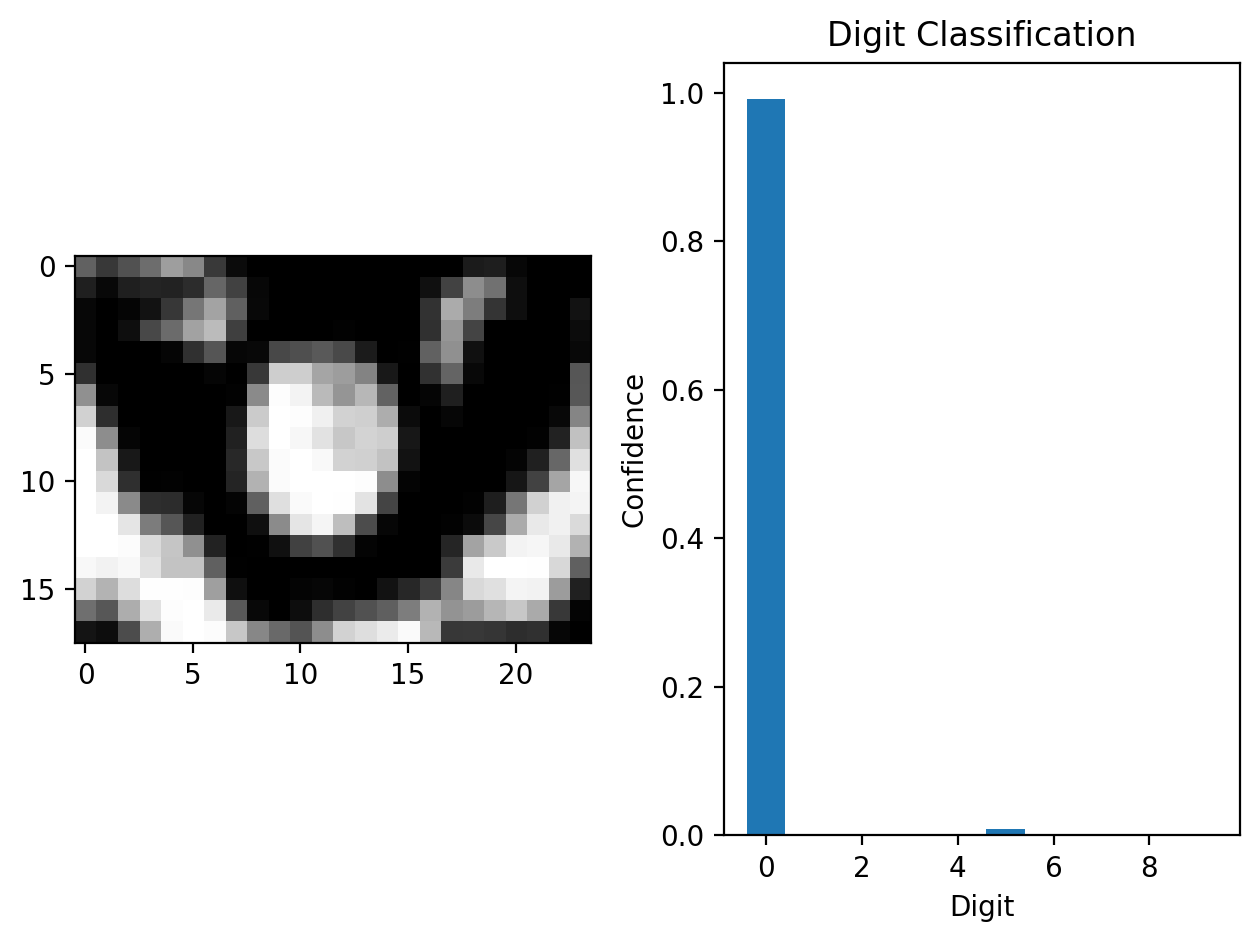

In [905]:
dataiter = iter(camera_trainloader)   # To iterate through the dataset
images, labels = next(dataiter)
img_array = images[0].numpy().reshape(img_res)

plt.subplot(1, 2, 1)
plt.imshow(img_array, cmap='binary')

img_array = img_array.reshape([1, 432])

with torch.no_grad():
    logprobs = my_MLP.forward(torch.from_numpy(img_array))


probs = np.exp(logprobs)
print(probs[0])
top_p, top_class = logprobs.topk(1, dim=1)


plt.subplot(1, 2, 2)
plt.bar([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], probs[0])
plt.xlabel("Digit")
plt.ylabel("Confidence")
plt.title("Digit Classification")
plt.tight_layout()

In [440]:
camera_performance = my_MLP.eval_performance(cameraloader)

print("Train Accuracy %f" %(camera_performance))

Train Accuracy 0.249107


### Activation Function Exploration

In [82]:
# Recreating the pytorch softmax function
# Scales down the exponents by the maximum input to prevent algorithmic overflow
def torch_softmax(x):
    maxes = torch.max(x, 1, keepdim=True)[0]
    x_exp = torch.exp(x-maxes)
    x_exp_sum = torch.sum(x_exp, 1, keepdim=True)
    probs = x_exp/x_exp_sum
    return probs 

# Modify: we can adjust the base of the exponent from e
# Scales down the exponents by the maximum input to prevent algorithmic overflow
def custom_softmax_scaled(base, x):
    maxes = torch.max(x, 1, keepdim=True)[0]
    x_exp = torch.pow(base, x-maxes)
    x_exp_sum = torch.sum(x_exp, 1, keepdim=True)
    probs = x_exp/x_exp_sum
    return probs

# Modify: we can adjust the base of the exponent from e
# No scaling
def custom_softmax(base, x):
    x_exp = torch.pow(base, x)
    x_exp_sum = torch.sum(x_exp, 1, keepdim=True)
    probs = x_exp/x_exp_sum
    return probs

In [89]:
m1 = nn.LogSoftmax(dim=1)
m2 = nn.Softmax(dim=1)
input = torch.randn(2, 3)
print("INPUT:")
print(input)
output1 = m1(input)
output2 = m2(input)
output3 = torch_softmax(input)
output4 = custom_softmax_scaled(2, input)
output5 = custom_softmax(2, input)
print("OUTPUT torch.exp(nn.LogSoftmax(dim=1)):")
print(torch.exp(output1))
print("OUTPUT nn.Softmax(dim=1):")
print(output2)
print("OUTPUT torch_softmax():")
print(output3)
print("OUTPUT custom_softmax_scaled(base=2):")
print(output4)
print("OUTPUT custom_softmax(base=2):")
print(output5)

INPUT:
tensor([[ 1.0983,  0.2267,  0.1991],
        [ 0.6197, -1.2169,  0.3530]])
OUTPUT torch.exp(nn.LogSoftmax(dim=1)):
tensor([[0.5479, 0.2292, 0.2229],
        [0.5194, 0.0828, 0.3978]])
OUTPUT nn.Softmax(dim=1):
tensor([[0.5479, 0.2292, 0.2229],
        [0.5194, 0.0828, 0.3978]])
OUTPUT torch_softmax():
tensor([[0.5479, 0.2292, 0.2229],
        [0.5194, 0.0828, 0.3978]])
OUTPUT custom_softmax_scaled(base=2):
tensor([[0.4801, 0.2624, 0.2574],
        [0.4737, 0.1326, 0.3937]])
OUTPUT custom_softmax(base=2):
tensor([[0.4801, 0.2624, 0.2574],
        [0.4737, 0.1326, 0.3937]])


### Testing on imported images:

Draw white on a black background: http://pixilart.com/draw/28x28-517d2f9c7af2f70#

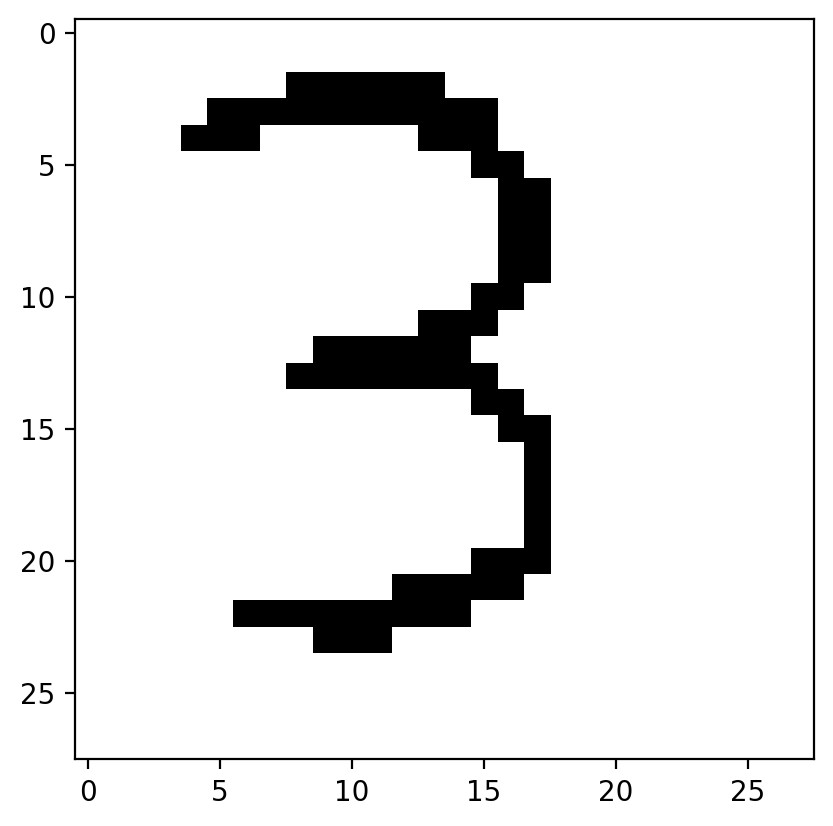

In [302]:
from PIL import Image

# Open the image
img = Image.open("drewDigits/drew3_1.png").convert('F')

# Convert to numpy array
import numpy as np
img_array = np.array(img)/260
fig = plt.imshow(img_array, cmap='binary')

In [305]:
### Run the model
img_array = img_array.reshape([1, 784])
img_array = np.where(img_array == 0, -1, img_array)

with torch.no_grad():
    #logprobs = my_MLP.forward(torch.from_numpy(img_array))
    
    logits = my_MLP.forward_preActivation(torch.from_numpy(img_array))
    print(logits)

#probs = np.exp(logprobs)
probs = torch_softmax(logits)
print(probs)
#probs = custom_softmax_scaled(2, logits)

print(torch.sum(probs))
top_p, top_class = logprobs.topk(1, dim=1)

plt.xlabel("Digit")
plt.ylabel("Confidence")
plt.title("Digit Classification")
plt.bar(labels.unique(), probs[0])

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x784 and 432x64)

### Visualize the model:

In [10]:
from torchviz import make_dot

# Generate the dot graph
dot = make_dot(my_MLP(torch.from_numpy(img_array)), params=dict(my_MLP.named_parameters()))

# Save the graph as a PDF
dot.render("model_visualization", format="pdf") 

'model_visualization.pdf'

3


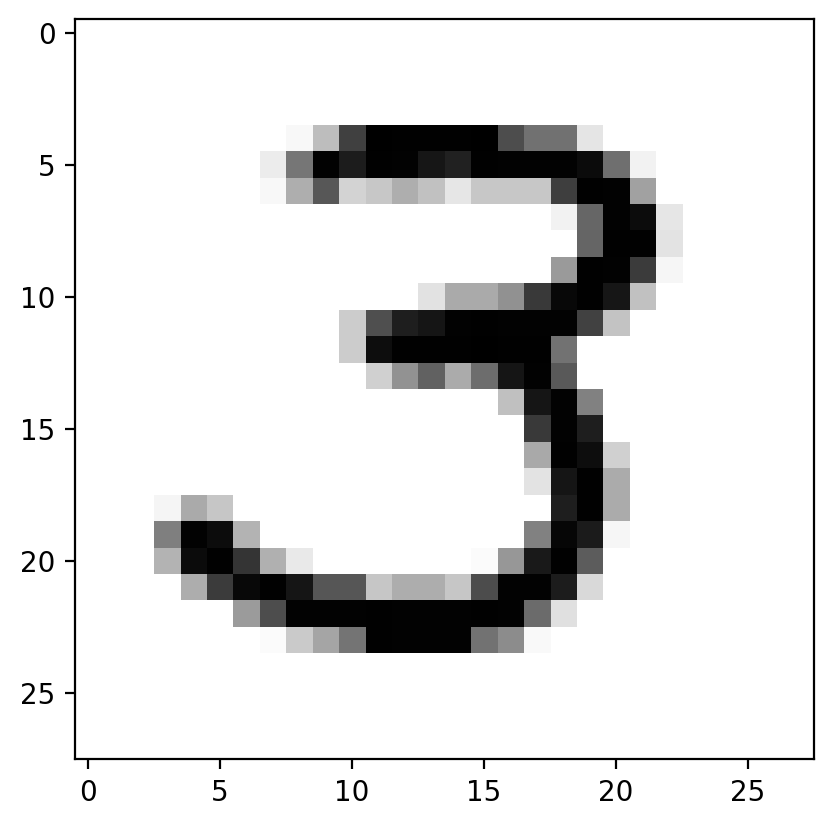

In [95]:
### FOR TESTING: how do the images in trainloader look to the model?

dataiter = iter(trainloader)   # To iterate through the dataset
images, labels = next(dataiter)

logprobs = my_MLP.forward(images.view(images.shape[0], -1))
top_p, top_class = logprobs.topk(1, dim=1)

plt.imshow(images[0].numpy().reshape(img_res), cmap='binary')
print(labels[0].item())